In [1]:
import numpy as np
from skimage.io import imread, imsave
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

In [5]:
def save_quivers(outdir, file_pattern1, file_pattern2, normed=False):
    #pos = self.pos()
    #vel = self.vel()
    for t in range(20):
        print(t)
        im = images[t]
        plt.imshow(im/np.max(im),cmap='gray', origin='lower')
        if normed:
            norm = np.sqrt(vel[:,:,t,0]**2 + vel[:,:,t,1]**2)
        else:
            norm = 1
        vx = vel[:,:,t,0]
        vy = vel[:,:,t,1]
        plt.quiver(w/2+pos[:,:,t,1],h/2+pos[:,:,t,0], vy/norm, vx/norm,cmap='gray')
        #fname = os.path.join(outdir, file_pattern1%(t))
        #plt.savefig(fname)
        plt.show()
        #plt.clf()
        #plt.quiver(w/2+pos[:,:,t,1],h/2+pos[:,:,t,0], vy/norm, vx/norm)
        #fname = os.path.join(outdir, file_pattern2%(t))
        #plt.savefig(fname)
        #plt.show()
        #plt.clf()

In [3]:
# Fit an exponential decay model to the velocity data
def residual_func(edt, nvmag, nt, nx, ny):
    def residuals(x):
        r0 = np.exp(x[0])
        C = 0  # x[1]
        res = []
        for frame in range(nt):
            for ix in range(nx):
                for iy in range(ny):
                    if not np.isnan(nvmag[frame, ix, iy]) and vfront[frame] > 1:
                        r = edt[frame, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                        B = 1 / (1 - np.exp(-rmax[t] / r0))
                        model_vmag = 1 + B * (np.exp(-r / r0) - 1)
                        #R = rmax[t]
                        #B = R / ((R - r0) + r0 * np.exp(-R / r0))    
                        #model_vmag = 1 + B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r) - 1)
    
                        mean_model_vmag = vfront[frame] * np.nanmean(model_vmag)
                        res.append(mean_model_vmag - nvmag[frame, ix, iy])
        return res

    return residuals

In [8]:
# Compute average growth rate of colony at each time point
# area = np.load('area.npy')
# sarea = savgol_filter(area, 5, 3)
# dsarea = savgol_filter(area, 5, 3, deriv=1)
# mean_growth_rate = dsarea / area
# np.save('mean_growth_rate.npy', mean_growth_rate)

# Compute colony edge velocity
# radius = np.load('radius.npy')
# vfront = savgol_filter(radius, 5, 3, deriv=1)
# np.save('vfront.npy', vfront)
# vfront = 6.585722451885091
# vfront = 65.8267122272761 / 60 * 10

start_frame = 11
# offset = 0
# end_frame = 80
step = 1

pos = 5

# Normalize velocity by edge vel
vmag = np.load(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos{pos}/vmag.npy')
#vmag = vmag[idx, :, :]
nt, nx, ny = vmag.shape

vfront = np.load(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos{pos}/vfront.npy')
rmax = np.load(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos{pos}/radius.npy')

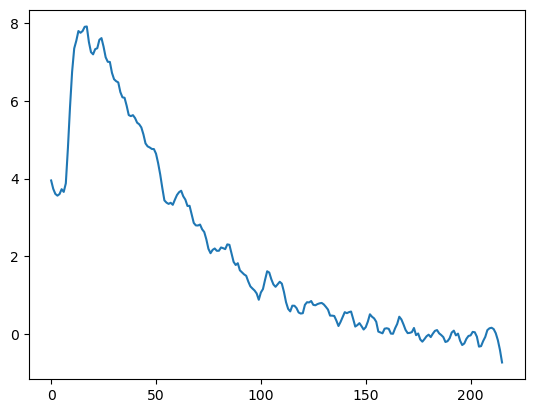

In [15]:
plt.plot(vfront)

0


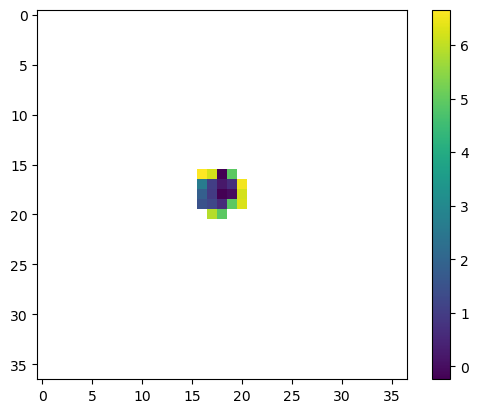

1


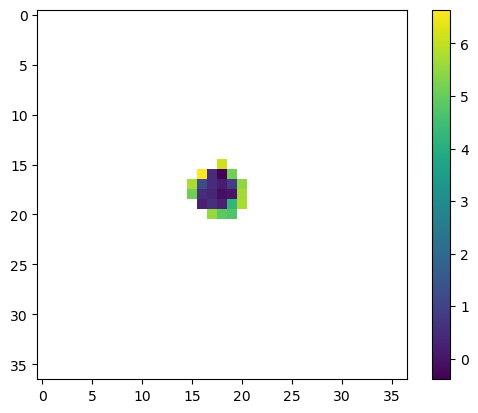

2


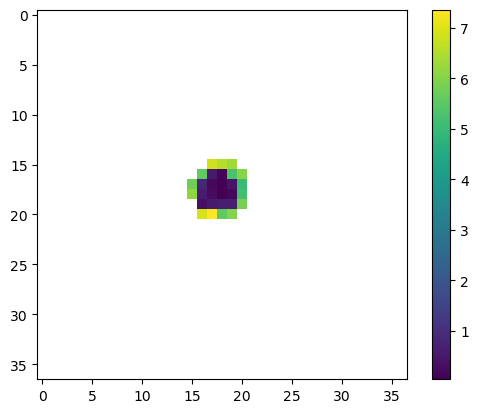

3


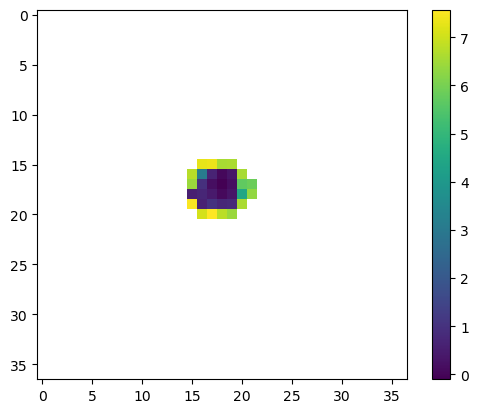

4


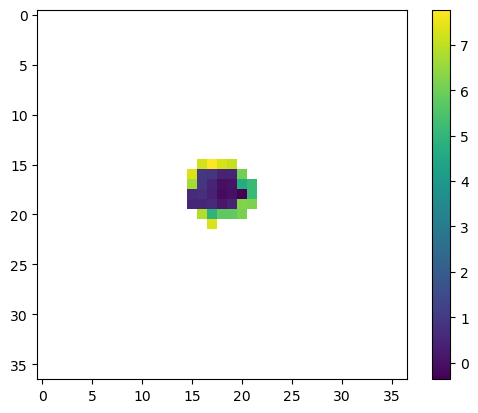

5


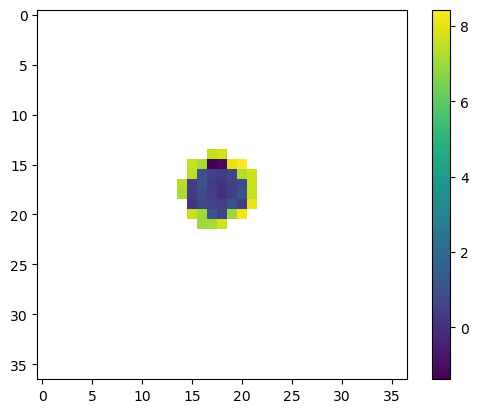

6


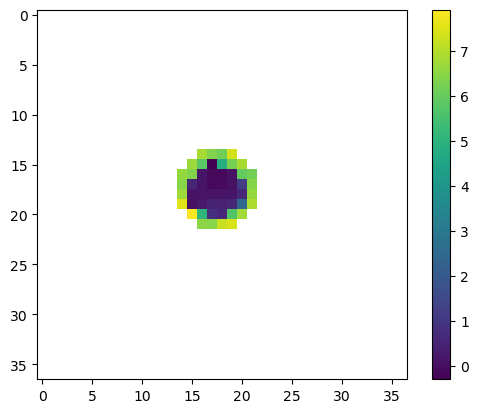

7


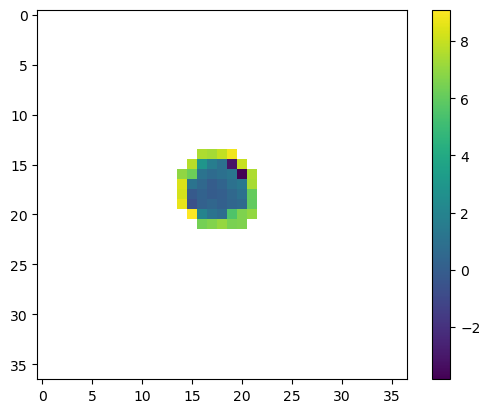

8


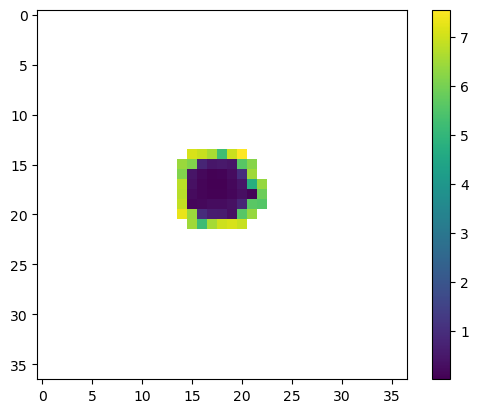

9


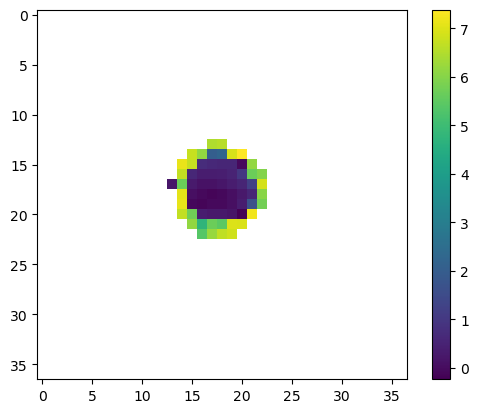

10


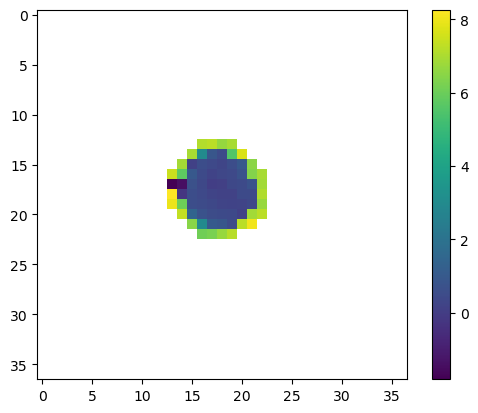

11


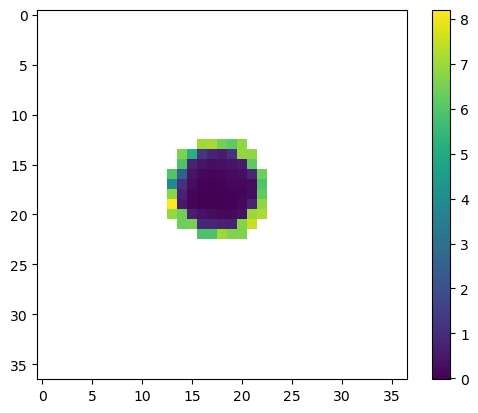

12


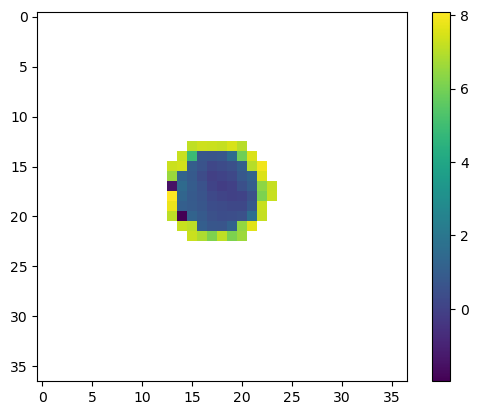

13


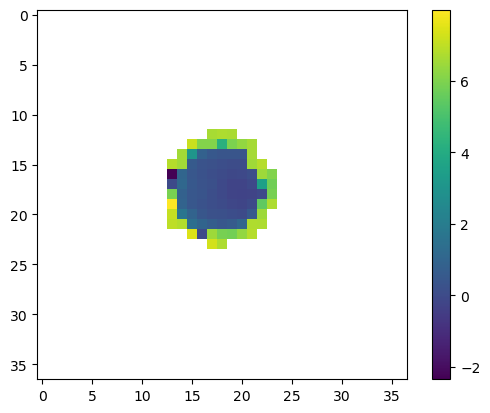

14


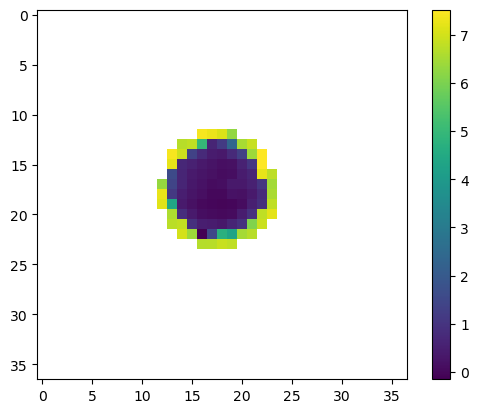

15


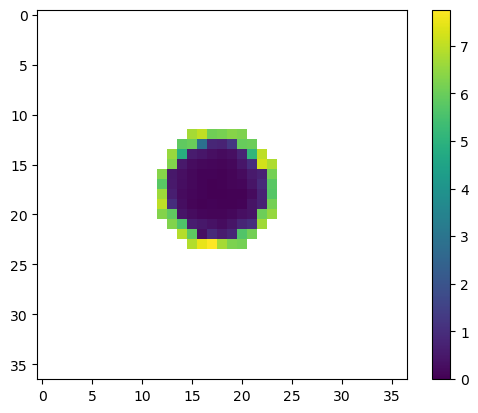

16


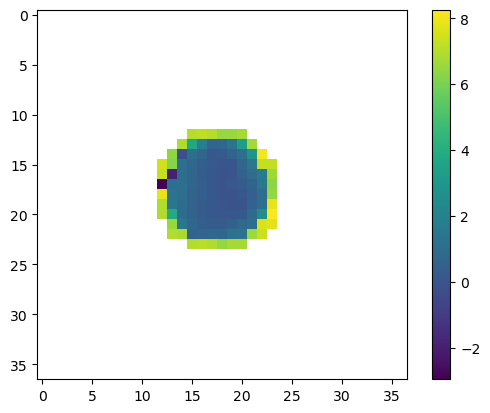

17


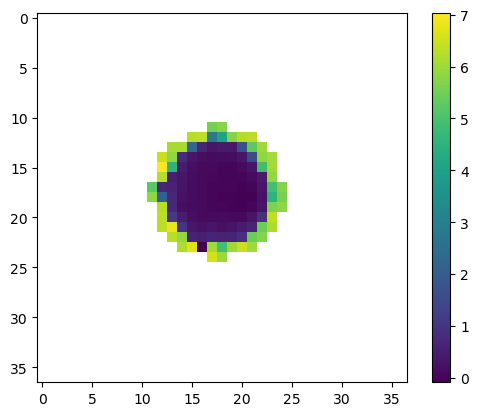

18


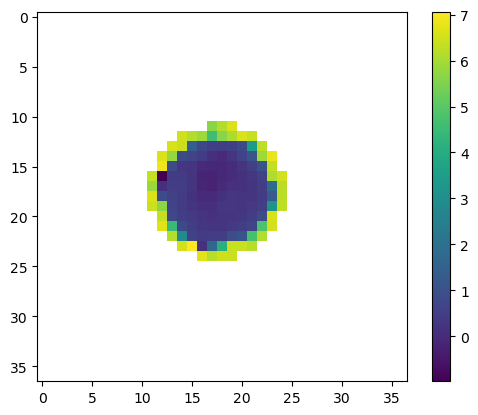

19


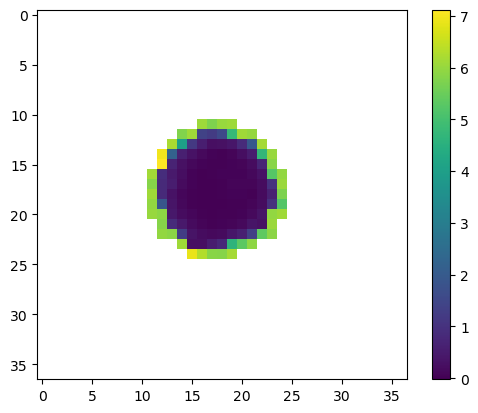

20


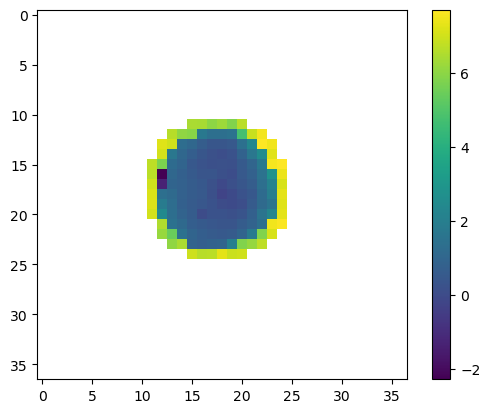

21


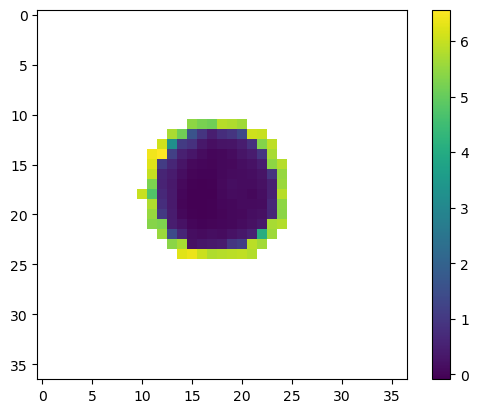

22


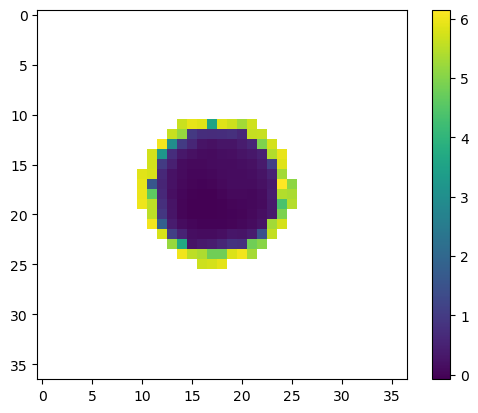

23


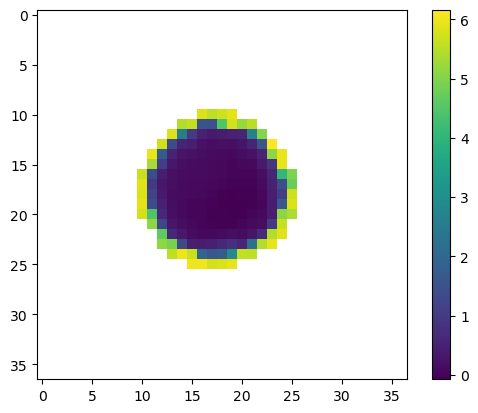

24


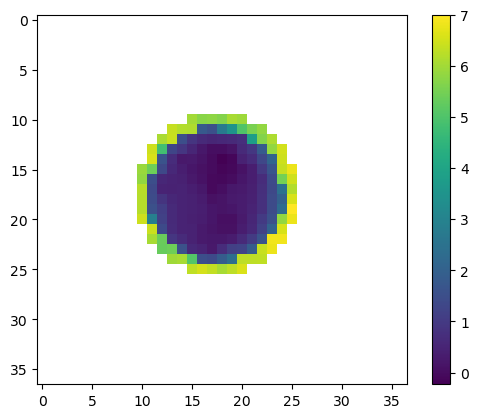

25


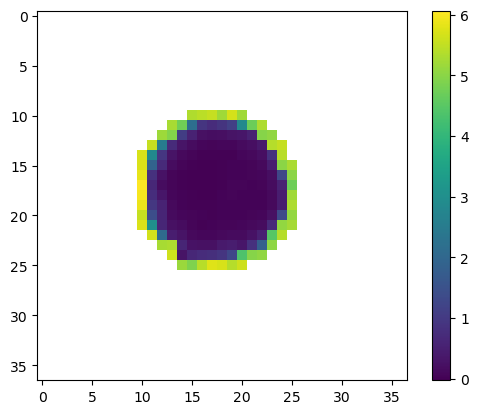

26


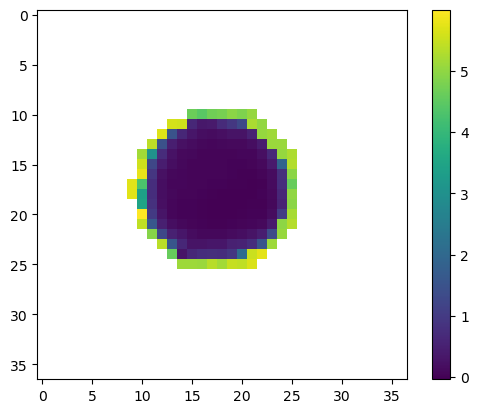

27


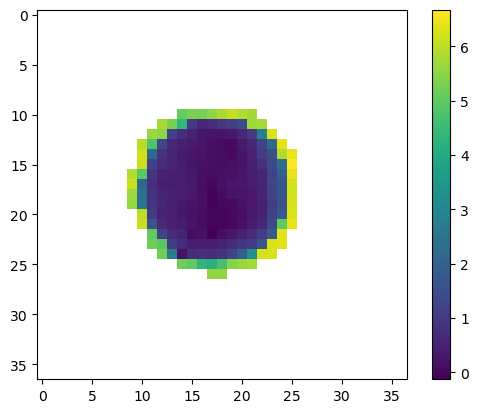

28


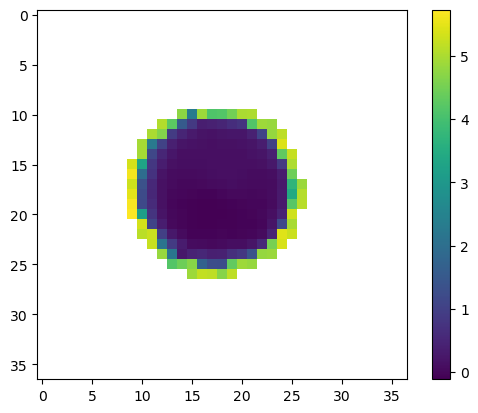

29


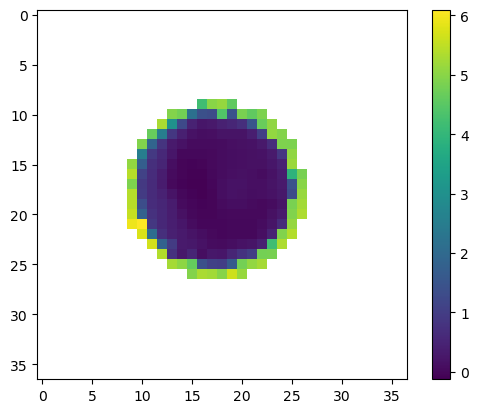

30


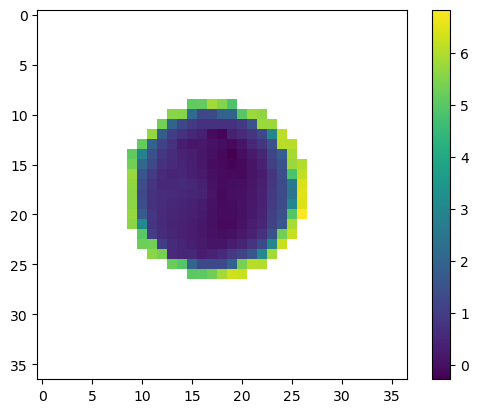

31


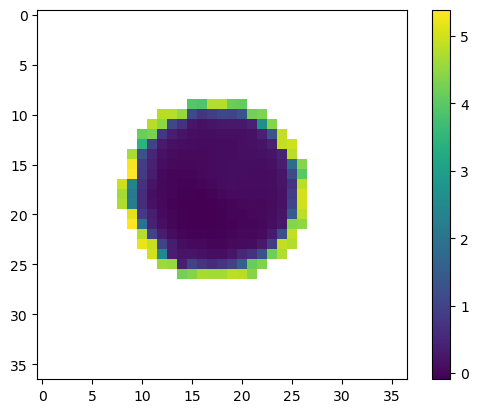

32


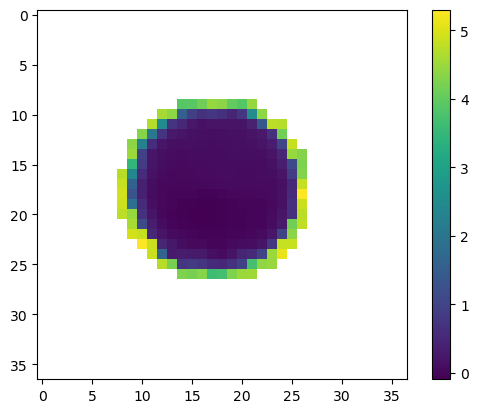

33


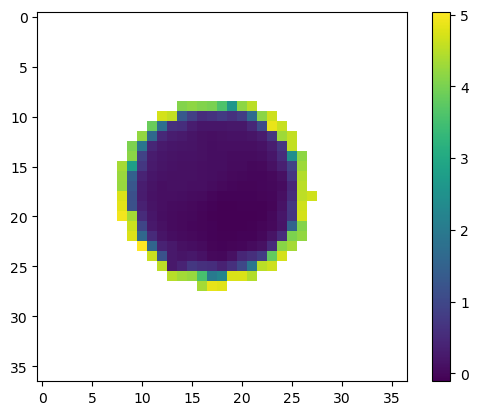

34


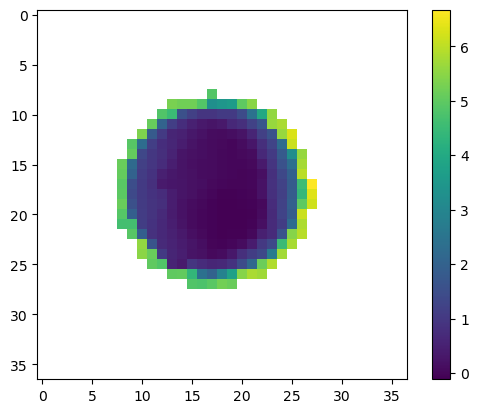

35


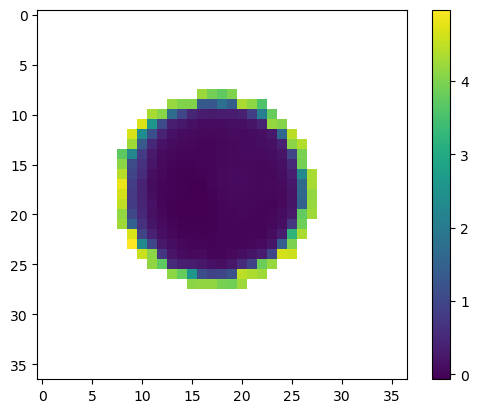

36


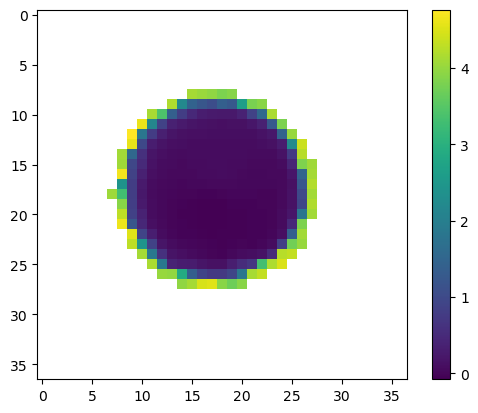

37


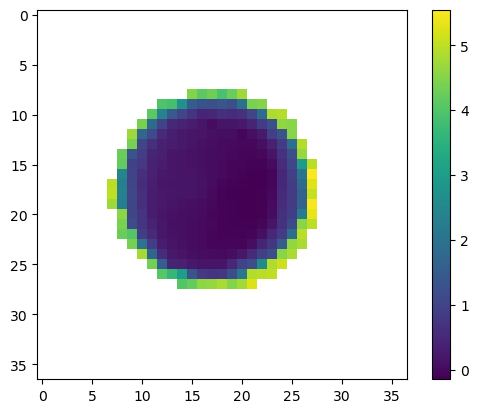

38


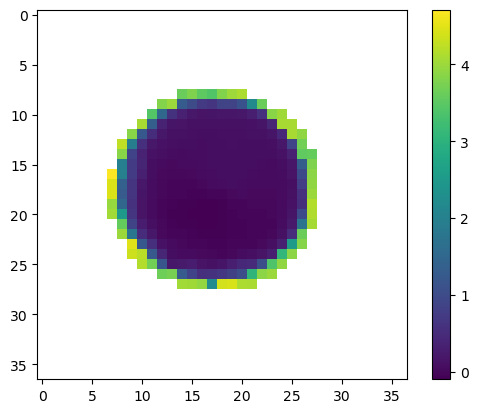

39


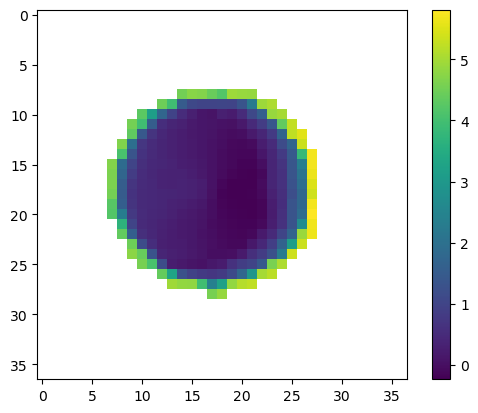

40


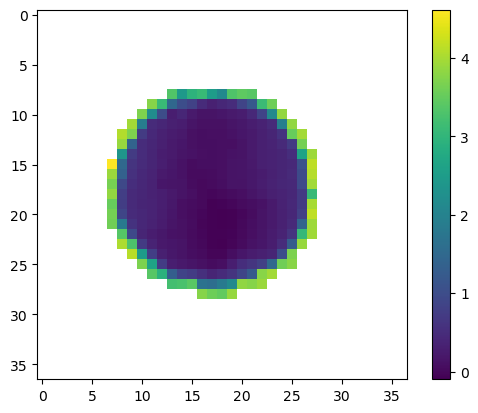

41


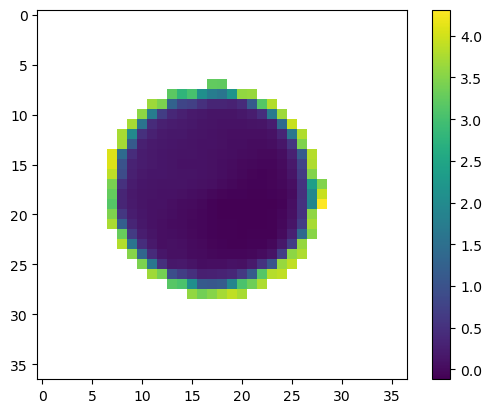

42


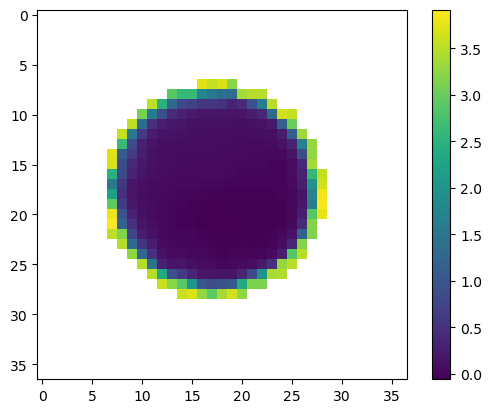

43


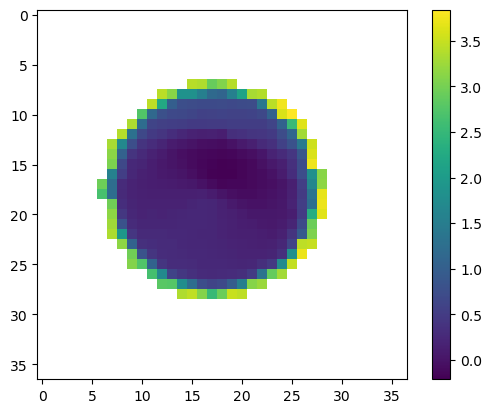

44


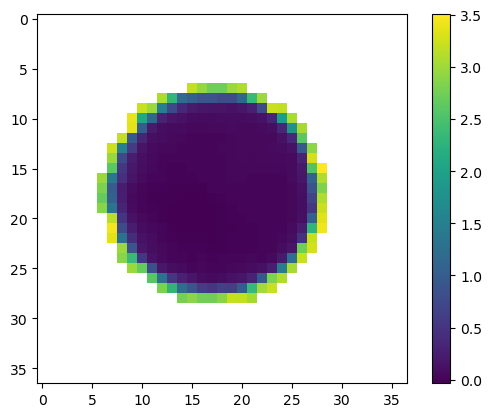

45


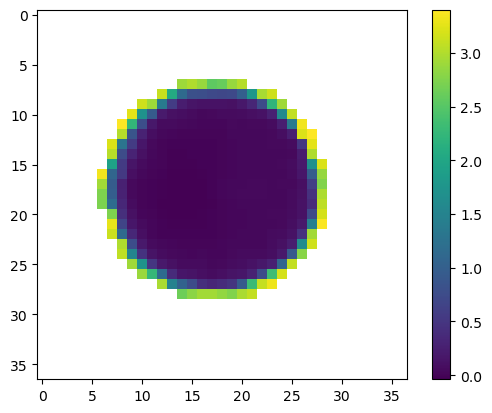

46


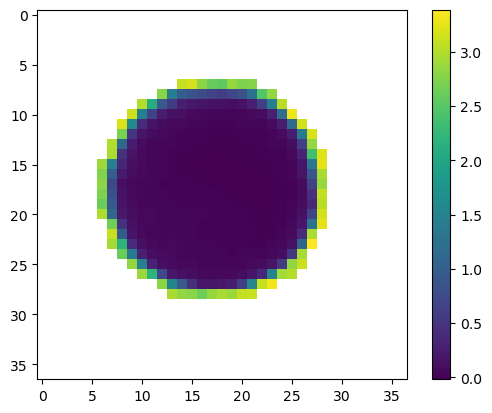

47


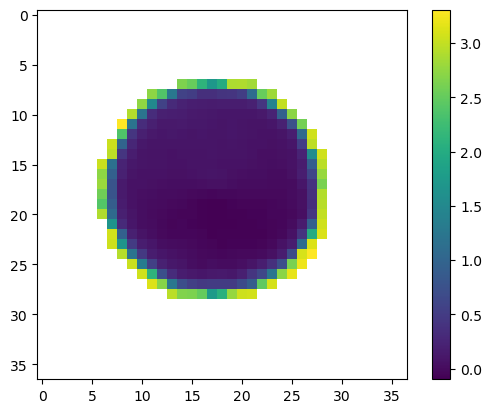

48


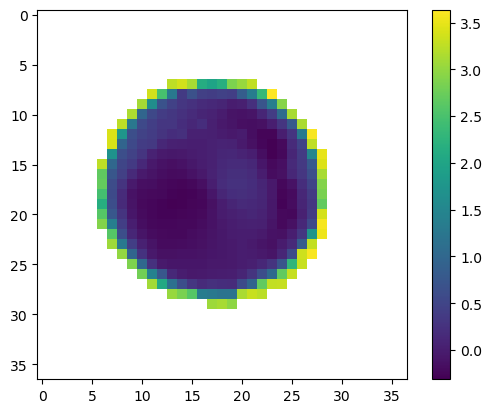

49


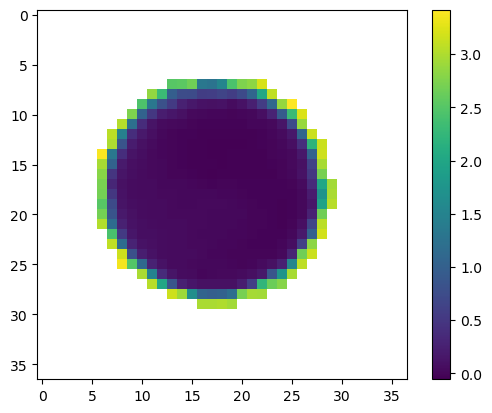

50


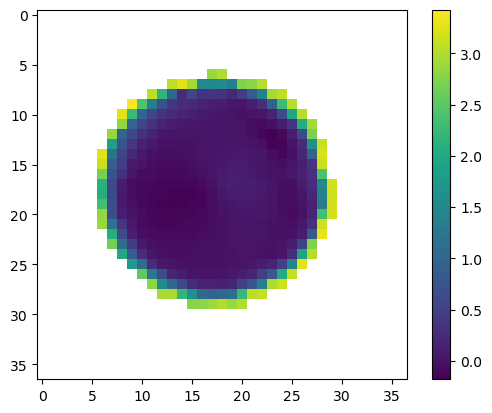

51


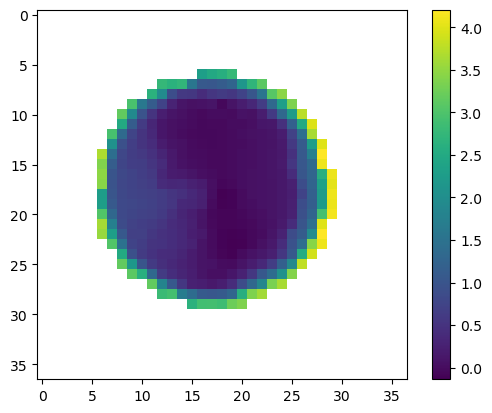

52


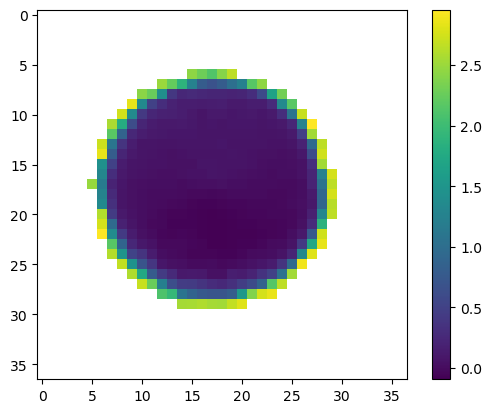

53


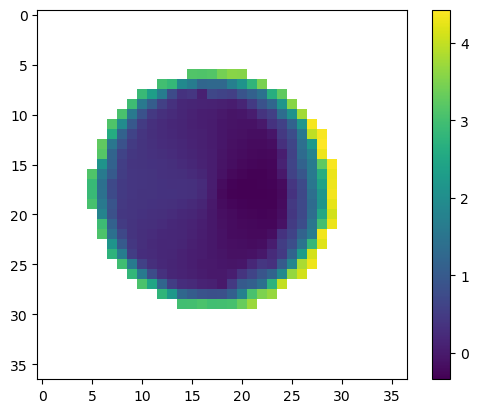

54


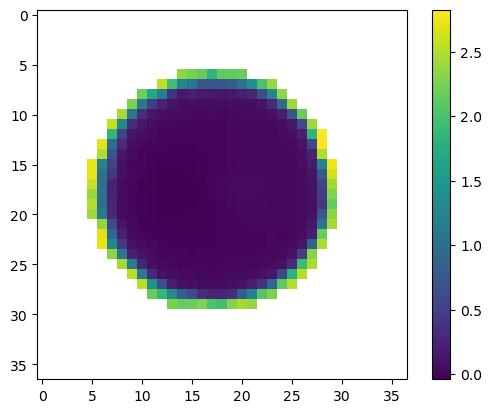

55


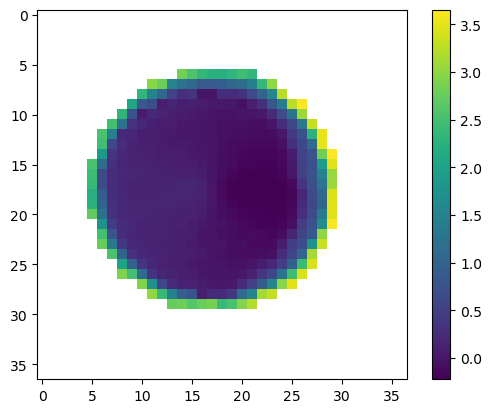

56


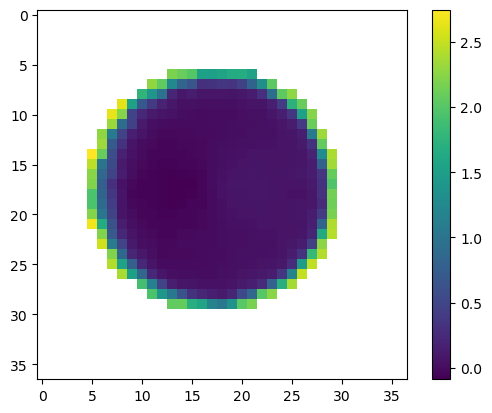

57


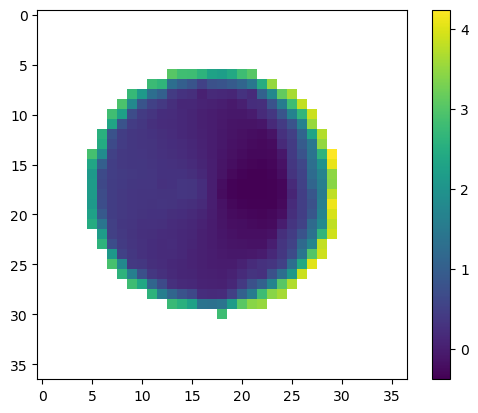

58


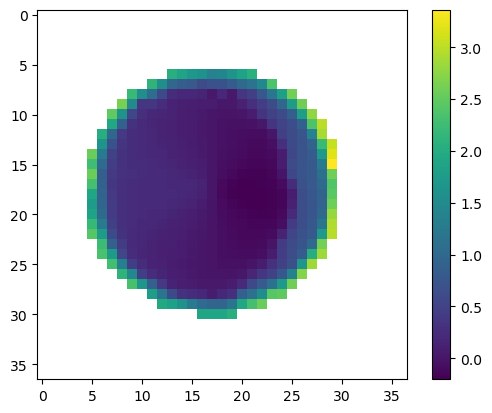

In [20]:
for i in range(59):
    print(i)
    plt.imshow(vmag[i])
    plt.colorbar()
    plt.show()

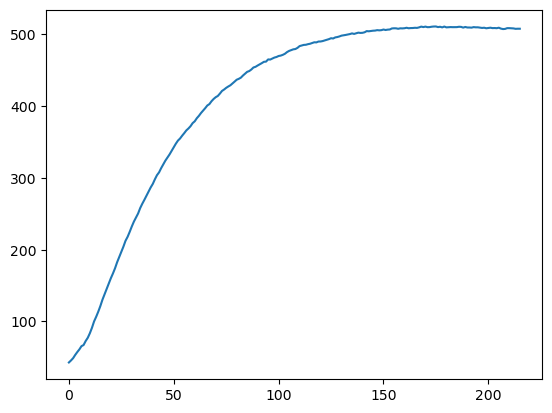

In [22]:
plt.plot(rmax)

In [23]:
vfront = vfront[:-1]
#idx = np.where((vfront > 3) * (rmax[1:] > 128))[0]
idx = np.arange(start_frame,nt+start_frame)
vfront = vfront[idx]
rmax = rmax[idx]
print(vfront.shape)

(59,)


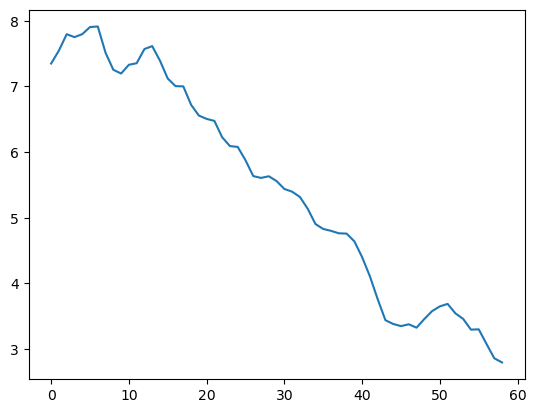

In [24]:
plt.plot(vfront)

In [6]:
edt = np.load(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos{pos}/edt.npy')
edt = edt[idx, :, :]

In [7]:
svmag = np.zeros_like(vmag) + np.nan
for t in range(nt):
    for ix in range(1, nx - 1):
        for iy in range(1, ny - 1):
            svmag[t, ix, iy] = np.nanmean(vmag[t, ix - 1:ix + 2, iy - 1:iy + 2])

nvmag = np.zeros_like(svmag)
for frame in range(nt):
    nvmag[frame, :, :] = svmag[frame, :, :] / vfront[frame * step + start_frame]
    #nvmag[frame, :, :] = svmag[frame, :, :] / vfront[frame * step]


radpos = np.load(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos{pos}/radpos.npy')
#radpos = radpos[idx, :, :]
# nvmag[~np.isnan(radpos)] = np.nan
# svmag[~np.isnan(radpos)] = np.nan

print("Size of svmag array along axis 0:", svmag.shape[0])

/tmp/ipykernel_288309/449463331.py:5: RuntimeWarning: Mean of empty slice
  svmag[t, ix, iy] = np.nanmean(vmag[t, ix - 1:ix + 2, iy - 1:iy + 2])


IndexError: index 53 is out of bounds for axis 0 with size 53

In [ ]:

res = least_squares(residual_func(edt, svmag, nt, nx, ny), x0=(np.log(50),))
r0 = np.exp(res.x[0])
C = 0  # res.x[1]

np.save(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos{pos}/r0.npy', r0)

print(f'r0 = {r0}, C = {C}')

In [ ]:
# Make a plot to see how good the fit is
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
i = 0
times = np.linspace(0, nt - 1, 12).astype(int)  # [0,int(nt/3),int(2*nt/3),nt-1]
for t in times:
    plt.subplot(4, 3, i + 1)
    x_model = np.zeros((0,))
    y_model = np.zeros((0,))
    x_data = np.zeros((0,))
    y_data = np.zeros((0,))

    for ix in range(nx):
        for iy in range(ny):
            if not np.isnan(svmag[t, ix, iy]):
                r = edt[t, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                x_data = np.append(x_data, np.nanmean(r))
                y_data = np.append(y_data, svmag[t, ix, iy])
    plt.plot(x_data, y_data, '.', alpha=0.2)  # , color=colours[i])

    for r in np.linspace(0, rmax[t], 100):
        R = rmax[t]
        B = R / ((R - r0) + r0 * np.exp(-R / r0))    
        model_vmag = 1 + B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r) - 1)
        #B = 1 / (1 - np.exp(-rmax[t] / r0))
        #model_vmag = 1 + B * (np.exp(-r / r0) - 1)
        mean_model_vmag = np.nanmean(model_vmag)
        x_model = np.append(x_model, np.nanmean(r))
        y_model = np.append(y_model, vfront[start_frame + step * t] * mean_model_vmag)
        #y_model = np.append(y_model, vfront[step * t] * mean_model_vmag)

    plt.plot(x_model, y_model, 'k--')  # , color=colours[i])

    i += 1

    plt.title(f't = {idx[t]}')
    plt.xlabel('Radial position')
    plt.ylabel('$v/v_{front}$')
plt.tight_layout()
plt.savefig(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/graphs/pos{pos}/vfront_rad.png')
plt.show()




In [ ]:
y_model = np.zeros((0,))
y_data = np.zeros((0,))
for t in range(nt):
    for ix in range(nx):
        for iy in range(ny):
            if not np.isnan(svmag[t, ix, iy]):
                r = edt[t, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                #B = 1 / (1 - np.exp(-rmax[t] / r0))
                #model_vmag = 1 + B * (np.exp(-r / r0) - 1)
                R = rmax[t]
                B = R / ((R - r0) + r0 * np.exp(-R / r0))    
                model_vmag = 1 + B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r) - 1)
                mean_model_vmag = np.nanmean(model_vmag)
                y_model = np.append(y_model, vfront[start_frame + step * t] * mean_model_vmag)
                #y_model = np.append(y_model, vfront[step * t] * mean_model_vmag)

                y_data = np.append(y_data, svmag[t, ix, iy])

plt.plot(y_model, y_data, '.', alpha=0.1)
plt.plot([0, y_model.max()], [0, y_model.max()], 'k--')
plt.xlabel('Model $v$')
plt.ylabel('Velocimetry $v$')
plt.savefig(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/graphs/pos{pos}/model_graph.png')
# plt.xscale('log')
# plt.yscale('log')
plt.show()




In [ ]:
mu0 = np.zeros((nt,))
for t in range(nt):

    R = rmax[t]
    B = R / ((R - r0) + r0 * np.exp(-R / r0))
    mu0 = (R / r0) * (vfront / ((R - r0) + r0 * np.exp(-R / r0))) 

    #B = 1 / (1 - np.exp(-rmax[t] / r0))
    #mu0[t] = 2 * vfront[step * t] / r0 * B

# The edge growth rate = 2 * edge velocity / r0 
plt.plot(mu0)
plt.savefig(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/graphs/pos{pos}/mu0_profile.png')
plt.show()
np.save(f'/media/guillermo/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_28/results/pos{pos}/mu0.npy', mu0)
